In [1]:
# enabling 3rd party widgets
# from google.colab import output
# output.enable_custom_widget_manager()
# output.disable_custom_widget_manager()

# interactive 3D plot
# !pip install ipympl
# %matplotlib widget

In [2]:
import os
import sys
import math
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

import time as time
import platform as platform

import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import L2
import h5py

tf.keras.backend.set_floatx('float32')

In [3]:
colab_flag = False
FTYPE = np.float32
ITYPE = np.int32

strategy = None
# strategy = tf.distribute.MirroredStrategy()

In [4]:
current_sys = platform.system()

if current_sys == 'Windows':
    dir_sep = '\\'
else:
    dir_sep = '/'

In [5]:
if colab_flag == True:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/Github/MLROM/KS/')

In [6]:
print(os.getcwd())

/home/rkaushik/Documents/Thesis/MLROM/KS


In [7]:
from tools.misc_tools import create_data_for_RNN, mytimecallback, SaveLosses, plot_losses, plot_reconstructed_data_KS, plot_latent_states_KS , readAndReturnLossHistories, sigmoidWarmupAndDecayLRSchedule
from tools.ae_v3 import Autoencoder
from tools.GRU_SingleStep_v6 import RNN_GRU

In [8]:
behaviour = 'initialiseAndTrainFromScratch'
# behaviour = 'loadCheckpointAndContinueTraining'
# behaviour = 'loadFinalNetAndPlot'

In [9]:
# setting seed for PRNGs
if behaviour == 'initialiseAndTrainFromScratch':
    prng_seed = 42
    np.random.seed(prng_seed)
    tf.random.set_seed(prng_seed)

In [10]:
gpus = tf.config.list_physical_devices('GPU')
print(gpus)

if colab_flag == False:
    if strategy is None:
        if gpus:
            gpu_to_use = 0
            tf.config.set_visible_devices(gpus[gpu_to_use], 'GPU')
    logical_devices = tf.config.list_logical_devices('GPU')
    print(logical_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]


2022-11-15 14:54:52.391599: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-15 14:54:52.391997: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-15 14:54:52.451797: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-15 14:54:52.452059: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-15 14:54:52.452356: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

In [11]:
# print(tf.test.gpu_device_name())
print(tf.config.list_physical_devices())
print(tf.config.list_logical_devices())
print(tf.__version__)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
[LogicalDevice(name='/device:CPU:0', device_type='CPU'), LogicalDevice(name='/device:GPU:0', device_type='GPU')]
2.8.1


# KS System

In [12]:
# setting up params (and saving, if applicable)
from numpy import *

if behaviour == 'initialiseAndTrainFromScratch':
    # making RNN save directory
    dir_name_rnn = os.getcwd() + dir_sep + 'saved_rnn'
    if not os.path.isdir(dir_name_rnn):
        os.makedirs(dir_name_rnn)

    counter = 0
    while True:
        dir_check = 'rnn_' + str(counter).zfill(3)
        if os.path.isdir(dir_name_rnn + dir_sep + dir_check):
            counter += 1
        else:
            break

    dir_name_rnn = dir_name_rnn + dir_sep + dir_check
    os.makedirs(dir_name_rnn)
    os.makedirs(dir_name_rnn+dir_sep+'plots')
    
    # autoencoder directory
    ae_idx = '020'
    dir_name_ae = os.getcwd()+'{ds}saved_ae{ds}ae_'.format(ds=dir_sep)+ae_idx
else:
    # RNN directory
    dir_name_rnn = os.getcwd()+'/saved_rnn/rnn_008'

    # reading AE directory
    with open(dir_name_rnn + '/sim_data_AE_params.txt') as f:
        lines = f.readlines()

    params_dict = eval(''.join(lines))

    dir_name_ae = params_dict['dir_name_ae']
    ae_idx = dir_name_ae[-3:]
    dir_name_ae = os.getcwd()+'/saved_ae/ae_'+ae_idx

    # reading RNN paramaters
    with open(dir_name_rnn + '/RNN_specific_data.txt') as f:
        lines = f.readlines()

    params_rnn_dict = eval(''.join(lines))

    dt_rnn = params_rnn_dict['dt_rnn']
    T_sample_input = params_rnn_dict['T_sample_input']
    T_sample_output = params_rnn_dict['T_sample_output']
    T_offset = params_rnn_dict['T_offset']
    return_params_arr = params_rnn_dict['return_params_arr']
    params = params_rnn_dict['params']
    try:
        normalize_dataset = params_rnn_dict['normalize_dataset']
    except:
        print("'normalize_dataset' not present in RNN_specific_data, set to False.")
        normalize_dataset = False
    try:
        stddev_multiplier = params_rnn_dict['stddev_multiplier']
    except:
        print("'stddev_multiplier' not present in RNN_specific_data, set to None.")
        stddev_multiplier = None
    try:
        skip_intermediate = params_rnn_dict['skip_intermediate']
    except:
        print("'skip_intermediate' not present in RNN_specific_data, set to 1.")
        skip_intermediate = 1
    try:
        normalization_type = params_rnn_dict['normalization_type']
    except:
        print("'normalization_type' not present in RNN_specific_data, set to 'stddev'.")
        normalization_type = 'stddev'
    try:
        dense_layer_act_func = params_rnn_dict['dense_layer_act_func']
    except:
        print("'dense_layer_act_func' not present in RNN_specific_data, set to 'linear'.")
        dense_layer_act_func = 'linear'
    

    normalization_arr = None
    try:
        with open(dir_name_rnn + '/final_net/rnn_normalization.txt') as f:
            lines = f.readlines()
        rnn_norm_arr_dict = eval(lines)
        normalization_arr = rnn_norm_arr_dict['normalization_arr']
    except:
        pass
    if os.path.exists(dir_name_rnn+dir_sep+'normalization_data.npz'):
        fl = np.load(dir_name_rnn+dir_sep+'normalization_data.npz', allow_pickle=True)
        normalization_arr = fl['normalization_arr'][0]

# reading simulation parameters
with open(dir_name_ae + dir_sep + 'ae_data.txt') as f:
    lines = f.readlines()
params_dict = eval(''.join(lines))
data_dir_idx = params_dict['data_dir_idx']
normalizeforae_flag = params_dict['normalizeforae_flag']
normalization_constant_arr_aedata = params_dict['normalization_constant_arr_aedata']
if os.path.exists(dir_name_ae+dir_sep+'normalization_data.npz'):
    fl = np.load(dir_name_ae+dir_sep+'normalization_data.npz', allow_pickle=True)
    normalization_constant_arr_aedata = fl['normalization_constant_arr_aedata'][0]

print('dir_name_rnn:', dir_name_rnn)
print('dir_name_ae:', dir_name_ae)
print('data_dir_idx:', data_dir_idx)

# loading data
dir_name_data = os.getcwd() + dir_sep + 'saved_data' + dir_sep + 'data_' + data_dir_idx
    
with open(dir_name_data + dir_sep + 'sim_data_params.txt') as f:
    lines = f.readlines()
params_dict = eval(''.join(lines))
params_mat = params_dict['params_mat']
# init_state = params_dict['init_state']
t0 = params_dict['t0']
T = params_dict['T']
delta_t = params_dict['delta_t']
numpoints_xgrid = params_dict['numpoints_xgrid']
length = params_dict['length']
return_params_arr = params_dict['return_params_arr']
normalize_flag_ogdata = params_dict['normalize_flag']
print('normalize_flag_ogdata:', normalize_flag_ogdata)
alldata_withparams_flag = params_dict['alldata_withparams_flag']

xgrid = length*np.linspace(0, 1, numpoints_xgrid)

fl = np.load(dir_name_data+dir_sep+'data.npz', allow_pickle=True)
all_data = fl['all_data']
boundary_idx_arr = fl['boundary_idx_arr']
normalization_constant_arr_ogdata = fl['normalization_constant_arr'][0]
initial_t0 = fl['initial_t0']
init_state_mat = fl['init_state_mat']

lyapunov_spectrum_mat = fl['lyapunov_spectrum_mat']

dir_name_rnn: /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_006
dir_name_ae: /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_020
data_dir_idx: 004
normalize_flag_ogdata: False


In [13]:
lyapunov_time_arr = np.empty(shape=lyapunov_spectrum_mat.shape[0], dtype=FTYPE)
for i in range(lyapunov_spectrum_mat.shape[0]):
    lyapunov_time_arr[i] = 1/lyapunov_spectrum_mat[i, 0]
    print('Case : {}, lyapunov exponent : {}, lyapunov time : {}s'.format(i+1, lyapunov_spectrum_mat[i, 0], lyapunov_time_arr[i]))

Case : 1, lyapunov exponent : 0.06465670311438651, lyapunov time : 15.466300964355469s


In [14]:
def plot(
        boundary_idx_arr,
        delta_t,
        all_data,
        xgrid,
        xticks_snapto=20,
        num_yticks=11,
    ):

    n = len(boundary_idx_arr)
    # '''
    num_cols = 1
    num_rows = 1
    factor = 1
    # fig = plt.figure(figsize=(7.5*num_cols, 7.5*num_rows))

    num_modes = xgrid.shape[0]

    prev_idx = 0
    for i in range(len(boundary_idx_arr)):
        next_idx = boundary_idx_arr[i]
        fig, ax = plt.subplots(figsize=(factor*7.5*num_cols, factor*5.0*num_rows))
        N = next_idx - prev_idx
        input_time = np.arange(0, N)*delta_t

        im = ax.imshow(all_data[prev_idx:next_idx, 0:num_modes].transpose(), aspect='auto', origin='lower')
        num_xticks = 1 + int((N*delta_t + 0.5*xticks_snapto) // xticks_snapto)
        # xticks = np.linspace(0, N, num_xticks, dtype=np.int32)
        xticks = np.arange(0, N, int((xticks_snapto+0.5*delta_t)//delta_t))
        ax.set_xticks(ticks=xticks)
        ax.set_xticklabels(np.round(xticks*delta_t, 1))
        ax.tick_params(axis='x', rotation=270+45)

        yticks = np.linspace(0, 1, num_yticks)*(len(xgrid)-1)
        yticklabels = np.round(np.linspace(0, 1, yticks.shape[0])*xgrid[-1], 2)
        ax.set_yticks(ticks=yticks)
        ax.set_yticklabels(yticklabels)

        ax.set_xlabel('Time')
        ax.set_ylabel(r'$x$')
        # ax.title.set_text(r'Latent States')

        plt.colorbar(im)
        plt.show()
        print('')

        prev_idx = next_idx

    # '''

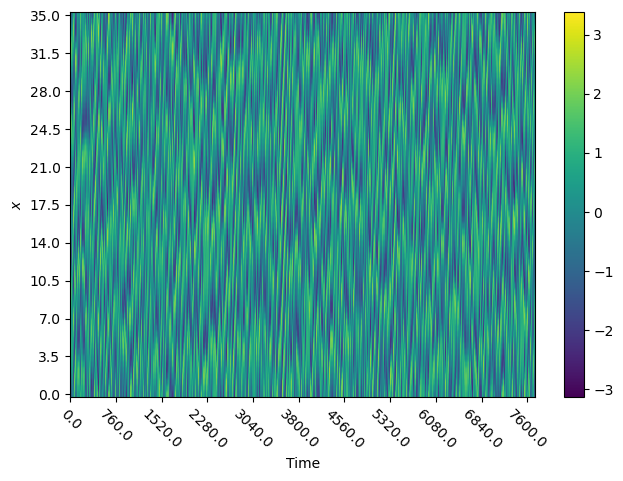

In [15]:
plot(
    boundary_idx_arr,
    delta_t,
    all_data,
    xgrid,
    xticks_snapto=int(40*np.round((T//10)/40))
)

In [16]:
# delaing with normalizing the data before feeding into autoencoder
if normalizeforae_flag == True:
    for i in range(numpoints_xgrid):
        all_data[:, i] -= normalization_constant_arr_aedata[0, i]
        all_data[:, i] /= normalization_constant_arr_aedata[1, i]

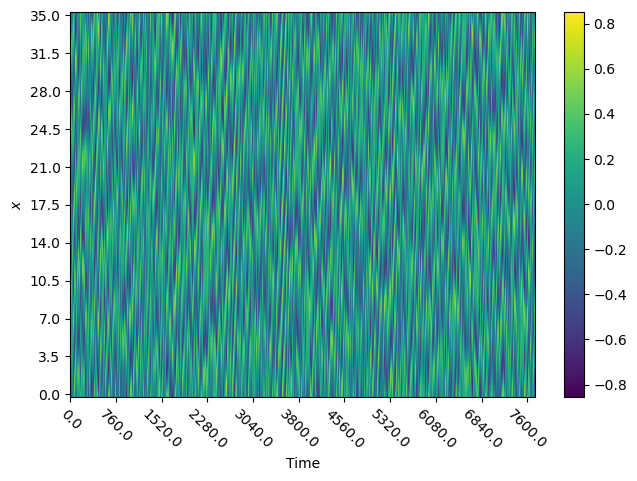

In [17]:
plot(
    boundary_idx_arr,
    delta_t,
    all_data,
    xgrid,
    xticks_snapto=int(40*np.round((T//10)/40))
)

# Autoencoder

In [18]:
# load_file = dir_name_ae+dir_sep+'new_class_data'+dir_sep+'ae_'+ae_idx+'_class_dict.txt'
# wt_file = dir_name_ae+dir_sep+'new_class_data'+dir_sep+'ae_'+ae_idx+'_ae_weights.h5'

# if colab_flag == False:
#     dir_name_ae_og = dir_name_ae
#     dir_name_ae_temp = '/home/rkaushik/Documents/Thesis/MLROM/CDV/saved_ae/ae_'+ae_idx
#     dir_name_ae = dir_name_ae_temp

load_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_class_dict.txt'
wt_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_ae_weights.h5'

# if colab_flag == False:
#     dir_name_ae = dir_name_ae_og

In [19]:
ae_net = Autoencoder(all_data.shape[1], load_file=load_file)
ae_net.load_weights_from_file(wt_file)

In [20]:
# create data
latent_states_all = ae_net.encoder_net.predict(all_data)
num_latent_states = latent_states_all.shape[1]

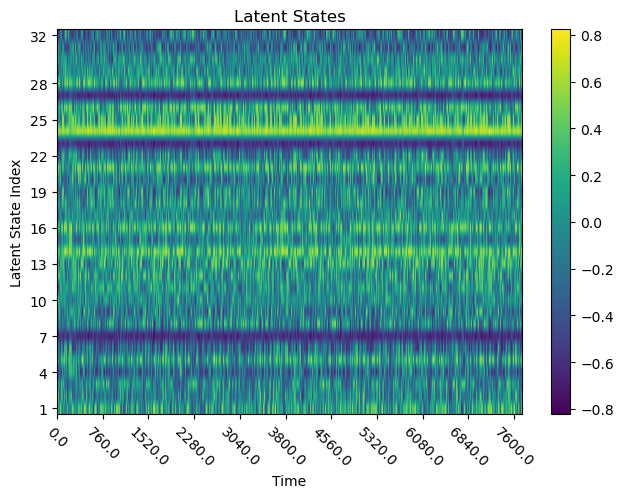

In [21]:
plot_latent_states_KS(
    boundary_idx_arr,
    latent_states_all,
    delta_t,
    dir_name_ae,
    xticks_snapto=int(40*np.round((T//10)/40)),
    num_yticks=11,
    save_figs=False)

In [22]:
# for i in range(ae_net.layers):
#     tf.keras.utils.plot_model(
#         ae_net.layers[i],
#         to_file=dir_name_ae+'/plots/netlayer_{}.png'.format(i),
#         show_shapes=True,
#         dpi=300
# )

# GRU

In [23]:
if behaviour == 'initialiseAndTrainFromScratch':
    # RNN data parameters
    num_lyaptimesteps_totrain = 5
    dt_rnn = 0.2
    T_sample_input = num_lyaptimesteps_totrain*np.mean(lyapunov_time_arr)
    T_sample_output = num_lyaptimesteps_totrain*np.mean(lyapunov_time_arr)
    T_offset = dt_rnn
    normalize_dataset = True # whether the data for the RNN should be normalized by the dataset's mean and std
    normalization_arr = None
    stddev_multiplier = 3
    skip_intermediate = 1/4
    noise_type = 'uniform'
    normalization_type = 'stddev' # can be 'minmax' or 'stddev', if it is
                                  # 'minmax' then stddev_multiplier has no effect
    dense_layer_act_func = ['linear']
        
    if return_params_arr != False:
        params = params_arr
    else:
        params = None
        
    timeMeanofSpaceRMS = np.mean(np.mean(latent_states_all**2, axis=1)**0.5)

    # saving simulation data
    sim_data = {
        'params_mat':params_mat,
        'init_state_mat':init_state_mat,
        't0':t0,
        'T':T,
        'delta_t':delta_t,
        'return_params_arr':return_params_arr,
        'dir_name_ae':dir_name_ae,
        'normalize_dataset':normalize_dataset,
        'stddev_multiplier':stddev_multiplier,
    }


    with open(dir_name_rnn+dir_sep+'sim_data_AE_params.txt', 'w') as f:
        f.write(str(sim_data))
        
    # saving RNN specific data
    RNN_specific_data = {
        'dt_rnn':dt_rnn,
        'T_sample_input':T_sample_input,
        'T_sample_output':T_sample_output,
        'T_offset':T_offset,
        'boundary_idx_arr':boundary_idx_arr,
        'delta_t':delta_t,
        'params':params,
        'return_params_arr':return_params_arr,
        'normalize_dataset':normalize_dataset,
        'num_lyaptimesteps_totrain':num_lyaptimesteps_totrain,
        'stddev_multiplier':stddev_multiplier,
        'skip_intermediate':skip_intermediate,
        'module':RNN_GRU.__module__,
        'noise_type':noise_type,
        'normalization_type':normalization_type,
        'dense_layer_act_func':dense_layer_act_func,
    }

    with open(dir_name_rnn+dir_sep+'RNN_specific_data.txt', 'w') as f:
        f.write(str(RNN_specific_data))

In [24]:
rnn_res_dict = create_data_for_RNN(
    latent_states_all,
    dt_rnn,
    T_sample_input,
    T_sample_output,
    T_offset,
    None,
    boundary_idx_arr,
    delta_t,
    params=params,
    return_numsamples=True,
    normalize_dataset=normalize_dataset,
    stddev_multiplier=stddev_multiplier,
    skip_intermediate=skip_intermediate,
    return_OrgDataIdxArr=False,
    normalization_arr_external=normalization_arr,
    normalization_type=normalization_type)
    
data_rnn_input = rnn_res_dict['data_rnn_input']
data_rnn_output = rnn_res_dict['data_rnn_output']
org_data_idx_arr_input = rnn_res_dict['org_data_idx_arr_input']
org_data_idx_arr_output = rnn_res_dict['org_data_idx_arr_output']
num_samples = rnn_res_dict['num_samples']
normalization_arr = rnn_res_dict['normalization_arr']
rnn_data_boundary_idx_arr = rnn_res_dict['rnn_data_boundary_idx_arr']

In [25]:
del(org_data_idx_arr_input)
del(org_data_idx_arr_output)
del(latent_states_all)

In [26]:
# setting up training params
if behaviour == 'initialiseAndTrainFromScratch':
    learning_rate_list = [1e-3, 1e-4, 1e-5]
    epochs = 1000
    patience = 25  # parameter for early stopping
    min_delta = 1e-6  # parameter for early stopping
    lambda_reg = 1e-4  # weight for regularizer
    train_split = 0.8
    val_split = 0.1
    test_split = 1 - train_split - val_split
    batch_size = 64
    fRMS = 0.025

    stddev = fRMS*timeMeanofSpaceRMS
    
    # saving training params
    training_specific_params = {
        'learning_rate_list':learning_rate_list,
        'epochs':epochs,
        'patience':patience,
        'min_delta':min_delta,
        'prng_seed':prng_seed,
        'train_split':train_split,
        'val_split':val_split,
        'batch_size':batch_size,
        'fRMS':fRMS,
        'timeMeanofSpaceRMS':timeMeanofSpaceRMS,
        'stddev':stddev,
    }

    with open(dir_name_rnn+dir_sep+'training_specific_params.txt', 'w') as f:
        f.write(str(training_specific_params))
    
    np.savez(
        dir_name_rnn+dir_sep+'normalization_data',
        normalization_arr=[normalization_arr],
    )
    
else:
    # dir_name_rnn_og = dir_name_rnn
    # dir_name_rnn_temp = '/home/rkaushik/Documents/Thesis/MLROM/CDV/saved_rnn/rnn_'+dir_name_rnn_og[-3:]
    # dir_name_rnn = dir_name_rnn_temp

    with open(dir_name_rnn + dir_sep + 'training_specific_params.txt') as f:
        lines = f.readlines()


    tparams_dict = eval(''.join(lines))

    learning_rate_list = tparams_dict['learning_rate_list']
    epochs = tparams_dict['epochs']
    patience = tparams_dict['patience']
    min_delta = tparams_dict['min_delta']
    prng_seed = tparams_dict['prng_seed']
    train_split = tparams_dict['train_split']
    val_split = tparams_dict['val_split']
    batch_size = tparams_dict['batch_size']

    test_split = 1 - train_split - val_split

    # setting seed for PRNGs
    np.random.seed(prng_seed)
    tf.random.set_seed(prng_seed)

In [27]:
# idx = np.arange(data_rnn_input.shape[0])
# np.random.shuffle(idx)
# boundary = int(np.round(train_split*data_rnn_input.shape[0]))

# training_data_rnn_input = data_rnn_input[idx[0:boundary]]
# training_data_rnn_output = data_rnn_output[idx[0:boundary]]

# testing_data_rnn_input = data_rnn_input[idx[boundary:]]
# testing_data_rnn_output = data_rnn_output[idx[boundary:]]

In [28]:
cum_samples = rnn_data_boundary_idx_arr[-1]
# idx = np.arange(cum_samples)
# np.random.shuffle(idx)
num_train = 0
num_val = 0
begin_idx = 0
for i in range(len(boundary_idx_arr)):
    num_samples = rnn_data_boundary_idx_arr[i] - begin_idx
    num_train += int( (1-test_split-val_split)*num_samples )
    num_val += int(val_split*num_samples)
    begin_idx = rnn_data_boundary_idx_arr[i]

# defining shapes
training_input_shape = [num_train]
training_input_shape.extend(data_rnn_input.shape[1:])

training_output_shape = [num_train]
training_output_shape.extend(data_rnn_output.shape[1:])

val_input_shape = [num_val]
val_input_shape.extend(data_rnn_input.shape[1:])

val_output_shape = [num_train]
val_output_shape.extend(data_rnn_output.shape[1:])

testing_input_shape = [cum_samples-num_train-num_val]
testing_input_shape.extend(data_rnn_input.shape[1:])

testing_output_shape = [cum_samples-num_train-num_val]
testing_output_shape.extend(data_rnn_output.shape[1:])

# defining required arrays
training_data_rnn_input = np.empty(shape=training_input_shape)
training_data_rnn_output = np.empty(shape=training_output_shape)

val_data_rnn_input = np.empty(shape=val_input_shape)
val_data_rnn_output = np.empty(shape=val_output_shape)

testing_data_rnn_input = np.empty(shape=testing_input_shape)
testing_data_rnn_output = np.empty(shape=testing_output_shape)

begin_idx = 0
training_data_rolling_count = 0
val_data_rolling_count = 0
testing_data_rolling_count = 0
for i in range(len(boundary_idx_arr)):
    idx = np.arange(begin_idx, rnn_data_boundary_idx_arr[i])
    # np.random.shuffle(idx)
    num_samples = idx.shape[0]
    num_train = int( (1-test_split-val_split)*num_samples )
    num_val = int(val_split*num_samples)

    training_data_rnn_input[training_data_rolling_count:training_data_rolling_count+num_train] = data_rnn_input[idx[0:num_train]]
    training_data_rnn_output[training_data_rolling_count:training_data_rolling_count+num_train] = data_rnn_output[idx[0:num_train]]
    training_data_rolling_count += num_train

    val_data_rnn_input[val_data_rolling_count:val_data_rolling_count+num_val] = data_rnn_input[idx[num_train:num_train+num_val]]
    val_data_rnn_output[val_data_rolling_count:val_data_rolling_count+num_val] = data_rnn_output[idx[num_train:num_train+num_val]]
    val_data_rolling_count += num_val

    num_test = num_samples-num_train-num_val+1
    testing_data_rnn_input[testing_data_rolling_count:testing_data_rolling_count+num_test] = data_rnn_input[idx[num_train+num_val:]]
    testing_data_rnn_output[testing_data_rolling_count:testing_data_rolling_count+num_test] = data_rnn_output[idx[num_train+num_val:]]
    testing_data_rolling_count += num_test

    begin_idx = rnn_data_boundary_idx_arr[i]

# cleaning up
del(data_rnn_input)
del(data_rnn_output)

# further shuffling
idx = np.arange(0, training_data_rnn_input.shape[0])
np.random.shuffle(idx)
training_data_rnn_input = training_data_rnn_input[idx]
training_data_rnn_output = training_data_rnn_output[idx]

idx = np.arange(0, val_data_rnn_input.shape[0])
np.random.shuffle(idx)
val_data_rnn_input = val_data_rnn_input[idx]
val_data_rnn_output = val_data_rnn_output[idx]

idx = np.arange(0, testing_data_rnn_input.shape[0])
np.random.shuffle(idx)
testing_data_rnn_input = testing_data_rnn_input[idx]
testing_data_rnn_output = testing_data_rnn_output[idx]

del(idx)

In [29]:
# Initialize network
if behaviour == 'initialiseAndTrainFromScratch':
    rnn_layers_units = [2**9+2**8]*1
#     timeMeanofSpaceRMS = np.mean(np.mean(latent_states_all**2, axis=1)**0.5)
    print('timeMeanofSpaceRMS :', timeMeanofSpaceRMS)
    print('stddev :', stddev)
    if return_params_arr != False:
        data_dim = num_latent_states + 3
    else:
        data_dim = num_latent_states

    dense_dim = [rnn_layers_units[-1]]*(len(dense_layer_act_func)-1)
    dense_dim.append(data_dim)
        
    if strategy is not None:
        with strategy.scope():
            rnn_net = RNN_GRU(
                data_dim=data_dim,
            #     in_steps=int(T_sample_input // dt_rnn),
            #     out_steps=int(T_sample_output // dt_rnn),
                dt_rnn=dt_rnn,
                lambda_reg=lambda_reg,
                reg_name='L2',
                rnn_layers_units=rnn_layers_units,
                dense_layer_act_func=dense_layer_act_func,
                load_file=None,
                # T_input=T_sample_input,
                # T_output=T_sample_output,
                stddev=stddev,
                noise_type=noise_type,
                dense_dim=dense_dim
            )
    else:
        rnn_net = RNN_GRU(
            data_dim=data_dim,
        #     in_steps=int(T_sample_input // dt_rnn),
        #     out_steps=int(T_sample_output // dt_rnn),
            dt_rnn=dt_rnn,
            lambda_reg=lambda_reg,
            reg_name='L2',
            rnn_layers_units=rnn_layers_units,
            dense_layer_act_func=dense_layer_act_func,
            load_file=None,
            # T_input=T_sample_input,
            # T_output=T_sample_output,
            stddev=stddev,
            noise_type=noise_type,
            dense_dim=dense_dim
        )
    save_path = dir_name_rnn+dir_sep+'final_net'
    if not os.path.isdir(save_path):
        os.makedirs(save_path)
    rnn_net.save_class_dict(save_path+dir_sep+'final_net_class_dict.txt')
else:
    load_file = dir_name_rnn + dir_sep + 'final_net' + dir_sep + 'final_net_class_dict.txt'
    if strategy is not None:
        with strategy.scope():
            rnn_net = RNN_GRU(
                load_file=load_file,
                # T_input=T_sample_input,
                # T_output=T_sample_output
            )
    else:
        rnn_net = RNN_GRU(
            load_file=load_file,
            # T_input=T_sample_input,
            # T_output=T_sample_output
        )
    
    if behaviour == 'loadCheckpointAndContinueTraining':
        wt_file = tf.train.latest_checkpoint(dir_name_rnn+dir_sep+'checkpoints')
    elif behaviour == 'loadFinalNetAndPlot':
        wt_file = dir_name_rnn+dir_sep+'final_net'+dir_sep+'final_net_gru_weights.h5'
        # wt_file = dir_name_rnn+dir_sep+'final_net'+dir_sep+'f2'#+dir_sep+'saved_model.pb'
        rnn_net.load_weights_from_file(wt_file)
    
    # this forces the model to initialize its kernel weights/biases
    # temp = rnn_net.predict(tf.ones(shape=[batch_size, int(T_sample_input//dt_rnn), rnn_net.data_dim]))
    # this loads just the kernel wieghts and biases of the model
#     rnn_net.load_weights_from_file(wt_file)

    # rnn_net = tf.keras.models.load_model(wt_file)

timeMeanofSpaceRMS : 0.40322953
stddev : 0.010080738365650177


In [30]:
if behaviour == 'initialiseAndTrainFromScratch':
    val_loss_hist = []
    train_loss_hist = []
    lr_change=[0, 0]
    savelosses_cb_vallossarr = np.ones(shape=epochs*len(learning_rate_list))*np.NaN
    savelosses_cb_trainlossarr = np.ones(shape=epochs*len(learning_rate_list))*np.NaN
    starting_lr_idx = 0
    num_epochs_left = epochs
    earlystopping_wait = 0
elif behaviour == 'loadCheckpointAndContinueTraining':
    val_loss_hist, train_loss_hist, lr_change, starting_lr_idx, num_epochs_left, val_loss_arr_fromckpt, train_loss_arr_fromckpt, earlystopping_wait = readAndReturnLossHistories(
        dir_name_ae=dir_name_rnn,
        dir_sep=dir_sep,
        epochs=epochs,
        learning_rate_list=learning_rate_list,
        return_earlystopping_wait=True)
    savelosses_cb_vallossarr = val_loss_arr_fromckpt
    savelosses_cb_trainlossarr = train_loss_arr_fromckpt
elif behaviour == 'loadFinalNetAndPlot':
    with open(dir_name_rnn+'{ds}final_net{ds}losses.txt'.format(ds=dir_sep), 'r') as f:
        lines = f.readlines()
    
    losses_dict = eval(''.join(lines))

    val_loss_hist = losses_dict['val_loss_hist']
    train_loss_hist = losses_dict['train_loss_hist']
    lr_change = losses_dict['lr_change']
    test_loss = losses_dict['test_loss']

In [31]:
# compiling the network
rnn_net.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate_list[0]),
    loss=losses.MeanSquaredError(),
    run_eagerly=False
)

if behaviour == 'loadCheckpointAndContinueTraining':
    # this loads the weights/attributes of the optimizer as well
    if strategy is not None:
        with strategy.scope():
            rnn_net.load_weights(wt_file)
    else:
        rnn_net.load_weights(wt_file)

if behaviour == 'initialiseAndTrainFromScratch' or behaviour == 'loadCheckpointAndContinueTraining':
    # implementing early stopping
    baseline = None
    if behaviour == 'loadCheckpointAndContinueTraining':
        baseline = np.min(val_loss_hist)
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=patience,
        restore_best_weights=True,
        verbose=True,
        min_delta=min_delta,
        baseline=baseline
    )
    #** the two lines below are useless because wait is set to 0 in on_train_begin
    # early_stopping_cb.wait = earlystopping_wait
    # print('early_stopping_cb.wait : {}\n'.format(early_stopping_cb.wait))

    # time callback for each epoch
    timekeeper_cb = mytimecallback()

    # model checkpoint callback
    dir_name_ckpt = dir_name_rnn+dir_sep+'checkpoints'
    if not os.path.isdir(dir_name_ckpt):
        os.makedirs(dir_name_ckpt)
    checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
        filepath=dir_name_ckpt+dir_sep+'checkpoint',#+'/checkpoint--loss={loss:.4f}--vall_loss={val_loss:.4f}',
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=True,
        verbose=2,
        initial_value_threshold=baseline,
        period=1  # saves every `period` epochs
    )

    # save losses callback
    savelosses_cb = SaveLosses(
        filepath=dir_name_ckpt+dir_sep+'LossHistoriesCheckpoint',
        val_loss_arr=savelosses_cb_vallossarr,
        train_loss_arr=savelosses_cb_trainlossarr,
        total_epochs=epochs,
        period=1)

    for i in range(starting_lr_idx, len(learning_rate_list)):
        learning_rate = learning_rate_list[i]
        K.set_value(rnn_net.optimizer.lr, learning_rate)

        savelosses_cb.update_lr_idx(i)

        if i == starting_lr_idx:
            EPOCHS = num_epochs_left
            savelosses_cb.update_offset(epochs-num_epochs_left)
        else:
            EPOCHS = epochs
            savelosses_cb.update_offset(0)

        total_s_len = 80
        sep_lr_s = ' LEARNING RATE : {} '.format(learning_rate)
        sep_lr_s = int((total_s_len - len(sep_lr_s))//2)*'-' + sep_lr_s
        sep_lr_s = sep_lr_s + (total_s_len-len(sep_lr_s))*'-'
        print('\n\n' + '-'*len(sep_lr_s))
        print('\n' + sep_lr_s+'\n')
        print('-'*len(sep_lr_s) + '\n\n')
        
        history = rnn_net.fit(training_data_rnn_input, training_data_rnn_output,
            epochs=EPOCHS,
            batch_size=batch_size,
#             validation_split=val_split/train_split,
            validation_data=(val_data_rnn_input, val_data_rnn_output),
            callbacks=[early_stopping_cb, timekeeper_cb, checkpoint_cb, savelosses_cb],
            verbose=1
        )

        val_loss_hist.extend(history.history['val_loss'])
        train_loss_hist.extend(history.history['loss'])
        
        if i == starting_lr_idx:
            lr_change[i+1] += len(history.history['val_loss'])
        else:
            lr_change.append(lr_change[i]+len(history.history['val_loss']))



--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 0.001 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/1000
5/5 [==============================] - ETA: 0s - loss: 0.1536 - tot_time: 0h 1m 29.7s

Epoch 1: val_loss improved from inf to 0.10604, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_006/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_006/checkpoints/LossHistoriesCheckpoint
5/5 [==============================] - 90s 4s/step - loss: 0.1536 - val_loss: 0.1060
Epoch 2/1000
5/5 [==============================] - ETA: 0s - loss: 0.1030 - tot_time: 0h 1m 33.2s

Epoch 2: val_loss improved from 0.10604 to 0.09708, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_006/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Docu

Epoch 18/1000
5/5 [==============================] - ETA: 0s - loss: 0.0762 - tot_time: 0h 2m 31.0s

Epoch 18: val_loss improved from 0.07653 to 0.07583, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_006/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_006/checkpoints/LossHistoriesCheckpoint
5/5 [==============================] - 4s 727ms/step - loss: 0.0762 - val_loss: 0.0758
Epoch 19/1000
5/5 [==============================] - ETA: 0s - loss: 0.0755 - tot_time: 0h 2m 34.5s

Epoch 19: val_loss improved from 0.07583 to 0.07512, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_006/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_006/checkpoints/LossHistoriesCheckpoint
5/5 [==============================] - 4s 728ms/step - loss: 0.0755 - val_loss: 0.0751
Epoch 20/1000
5/5 [==============================] - ETA: 0s - loss: 0.0748 

Epoch 36/1000
5/5 [==============================] - ETA: 0s - loss: 0.0645 - tot_time: 0h 3m 35.4s

Epoch 36: val_loss improved from 0.06481 to 0.06422, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_006/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_006/checkpoints/LossHistoriesCheckpoint
5/5 [==============================] - 4s 724ms/step - loss: 0.0645 - val_loss: 0.0642
Epoch 37/1000
5/5 [==============================] - ETA: 0s - loss: 0.0640 - tot_time: 0h 3m 39.0s

Epoch 37: val_loss improved from 0.06422 to 0.06364, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_006/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_006/checkpoints/LossHistoriesCheckpoint
5/5 [==============================] - 4s 749ms/step - loss: 0.0640 - val_loss: 0.0636
Epoch 38/1000
5/5 [==============================] - ETA: 0s - loss: 0.0634 

Epoch 54/1000
5/5 [==============================] - ETA: 0s - loss: 0.0549 - tot_time: 0h 4m 40.2s

Epoch 54: val_loss improved from 0.05517 to 0.05469, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_006/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_006/checkpoints/LossHistoriesCheckpoint
5/5 [==============================] - 4s 740ms/step - loss: 0.0549 - val_loss: 0.0547
Epoch 55/1000
5/5 [==============================] - ETA: 0s - loss: 0.0545 - tot_time: 0h 4m 43.8s

Epoch 55: val_loss improved from 0.05469 to 0.05422, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_006/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_006/checkpoints/LossHistoriesCheckpoint
5/5 [==============================] - 4s 734ms/step - loss: 0.0545 - val_loss: 0.0542
Epoch 56/1000
5/5 [==============================] - ETA: 0s - loss: 0.0540 

Epoch 72/1000
5/5 [==============================] - ETA: 0s - loss: 0.0471 - tot_time: 0h 5m 45.1s

Epoch 72: val_loss improved from 0.04731 to 0.04693, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_006/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_006/checkpoints/LossHistoriesCheckpoint
5/5 [==============================] - 4s 744ms/step - loss: 0.0471 - val_loss: 0.0469
Epoch 73/1000
5/5 [==============================] - ETA: 0s - loss: 0.0467 - tot_time: 0h 5m 48.7s

Epoch 73: val_loss improved from 0.04693 to 0.04654, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_006/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_006/checkpoints/LossHistoriesCheckpoint
5/5 [==============================] - 4s 733ms/step - loss: 0.0467 - val_loss: 0.0465
Epoch 74/1000
5/5 [==============================] - ETA: 0s - loss: 0.0463 

Epoch 90/1000
5/5 [==============================] - ETA: 0s - loss: 0.0408 - tot_time: 0h 6m 49.6s

Epoch 90: val_loss improved from 0.04105 to 0.04067, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_006/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_006/checkpoints/LossHistoriesCheckpoint
5/5 [==============================] - 4s 735ms/step - loss: 0.0408 - val_loss: 0.0407
Epoch 91/1000
5/5 [==============================] - ETA: 0s - loss: 0.0405 - tot_time: 0h 6m 53.2s

Epoch 91: val_loss improved from 0.04067 to 0.04040, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_006/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_006/checkpoints/LossHistoriesCheckpoint
5/5 [==============================] - 4s 774ms/step - loss: 0.0405 - val_loss: 0.0404
Epoch 92/1000
5/5 [==============================] - ETA: 0s - loss: 0.0402 

Epoch 108/1000
5/5 [==============================] - ETA: 0s - loss: 0.0353 - tot_time: 0h 7m 54.1s

Epoch 108: val_loss improved from 0.03552 to 0.03524, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_006/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_006/checkpoints/LossHistoriesCheckpoint
5/5 [==============================] - 4s 728ms/step - loss: 0.0353 - val_loss: 0.0352
Epoch 109/1000
5/5 [==============================] - ETA: 0s - loss: 0.0351 - tot_time: 0h 7m 57.7s

Epoch 109: val_loss improved from 0.03524 to 0.03509, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_006/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_006/checkpoints/LossHistoriesCheckpoint
5/5 [==============================] - 4s 734ms/step - loss: 0.0351 - val_loss: 0.0351
Epoch 110/1000
5/5 [==============================] - ETA: 0s - loss: 0.

Epoch 126/1000
5/5 [==============================] - ETA: 0s - loss: 0.0307 - tot_time: 0h 8m 59.0s

Epoch 126: val_loss improved from 0.03084 to 0.03071, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_006/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_006/checkpoints/LossHistoriesCheckpoint
5/5 [==============================] - 4s 731ms/step - loss: 0.0307 - val_loss: 0.0307
Epoch 127/1000
5/5 [==============================] - ETA: 0s - loss: 0.0305 - tot_time: 0h 9m 2.7s

Epoch 127: val_loss improved from 0.03071 to 0.03058, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_006/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_006/checkpoints/LossHistoriesCheckpoint
5/5 [==============================] - 4s 766ms/step - loss: 0.0305 - val_loss: 0.0306
Epoch 128/1000
5/5 [==============================] - ETA: 0s - loss: 0.0

Epoch 144/1000
5/5 [==============================] - ETA: 0s - loss: 0.0267 - tot_time: 0h 10m 3.7s

Epoch 144: val_loss improved from 0.02690 to 0.02667, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_006/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_006/checkpoints/LossHistoriesCheckpoint
5/5 [==============================] - 4s 741ms/step - loss: 0.0267 - val_loss: 0.0267
Epoch 145/1000
5/5 [==============================] - ETA: 0s - loss: 0.0265 - tot_time: 0h 10m 7.4s

Epoch 145: val_loss improved from 0.02667 to 0.02642, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_006/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_006/checkpoints/LossHistoriesCheckpoint
5/5 [==============================] - 4s 730ms/step - loss: 0.0265 - val_loss: 0.0264
Epoch 146/1000
5/5 [==============================] - ETA: 0s - loss: 0.

Epoch 162/1000
5/5 [==============================] - ETA: 0s - loss: 0.0233 - tot_time: 0h 11m 8.3s

Epoch 162: val_loss improved from 0.02343 to 0.02321, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_006/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_006/checkpoints/LossHistoriesCheckpoint
5/5 [==============================] - 4s 740ms/step - loss: 0.0233 - val_loss: 0.0232
Epoch 163/1000
5/5 [==============================] - ETA: 0s - loss: 0.0231 - tot_time: 0h 11m 12.0s

Epoch 163: val_loss improved from 0.02321 to 0.02312, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_006/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_006/checkpoints/LossHistoriesCheckpoint
5/5 [==============================] - 4s 737ms/step - loss: 0.0231 - val_loss: 0.0231
Epoch 164/1000
5/5 [==============================] - ETA: 0s - loss: 0

Epoch 180/1000
5/5 [==============================] - ETA: 0s - loss: 0.0205 - tot_time: 0h 12m 13.1s

Epoch 180: val_loss improved from 0.02065 to 0.02042, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_006/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_006/checkpoints/LossHistoriesCheckpoint
5/5 [==============================] - 4s 725ms/step - loss: 0.0205 - val_loss: 0.0204
Epoch 181/1000
5/5 [==============================] - ETA: 0s - loss: 0.0203 - tot_time: 0h 12m 16.7s

Epoch 181: val_loss improved from 0.02042 to 0.02023, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_006/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_006/checkpoints/LossHistoriesCheckpoint
5/5 [==============================] - 4s 735ms/step - loss: 0.0203 - val_loss: 0.0202
Epoch 182/1000
5/5 [==============================] - ETA: 0s - loss: 

Epoch 198/1000
5/5 [==============================] - ETA: 0s - loss: 0.0179 - tot_time: 0h 13m 18.0s

Epoch 198: val_loss improved from 0.01805 to 0.01790, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_006/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_006/checkpoints/LossHistoriesCheckpoint
5/5 [==============================] - 4s 738ms/step - loss: 0.0179 - val_loss: 0.0179
Epoch 199/1000
5/5 [==============================] - ETA: 0s - loss: 0.0177 - tot_time: 0h 13m 21.6s

Epoch 199: val_loss improved from 0.01790 to 0.01765, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_006/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_006/checkpoints/LossHistoriesCheckpoint
5/5 [==============================] - 4s 743ms/step - loss: 0.0177 - val_loss: 0.0176
Epoch 200/1000
5/5 [==============================] - ETA: 0s - loss: 

5/5 [==============================] - ETA: 0s - loss: 0.0156 - tot_time: 0h 14m 22.4s

Epoch 216: val_loss improved from 0.01566 to 0.01553, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_006/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_006/checkpoints/LossHistoriesCheckpoint
5/5 [==============================] - 4s 720ms/step - loss: 0.0156 - val_loss: 0.0155
Epoch 217/1000
5/5 [==============================] - ETA: 0s - loss: 0.0154 - tot_time: 0h 14m 25.9s

Epoch 217: val_loss improved from 0.01553 to 0.01539, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_006/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_006/checkpoints/LossHistoriesCheckpoint
5/5 [==============================] - 4s 731ms/step - loss: 0.0154 - val_loss: 0.0154
Epoch 218/1000
5/5 [==============================] - ETA: 0s - loss: 0.0152 - tot_ti

Epoch 234/1000
5/5 [==============================] - ETA: 0s - loss: 0.0135 - tot_time: 0h 15m 26.8s

Epoch 234: val_loss improved from 0.01370 to 0.01349, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_006/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_006/checkpoints/LossHistoriesCheckpoint
5/5 [==============================] - 4s 746ms/step - loss: 0.0135 - val_loss: 0.0135
Epoch 235/1000
5/5 [==============================] - ETA: 0s - loss: 0.0134 - tot_time: 0h 15m 30.4s

Epoch 235: val_loss improved from 0.01349 to 0.01341, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_006/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_006/checkpoints/LossHistoriesCheckpoint
5/5 [==============================] - 4s 737ms/step - loss: 0.0134 - val_loss: 0.0134
Epoch 236/1000
5/5 [==============================] - ETA: 0s - loss: 

Epoch 252/1000
5/5 [==============================] - ETA: 0s - loss: 0.0118 - tot_time: 0h 16m 31.6s

Epoch 252: val_loss improved from 0.01188 to 0.01174, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_006/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_006/checkpoints/LossHistoriesCheckpoint
5/5 [==============================] - 4s 736ms/step - loss: 0.0118 - val_loss: 0.0117
Epoch 253/1000
5/5 [==============================] - ETA: 0s - loss: 0.0116 - tot_time: 0h 16m 35.2s

Epoch 253: val_loss improved from 0.01174 to 0.01162, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_006/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_006/checkpoints/LossHistoriesCheckpoint
5/5 [==============================] - 4s 732ms/step - loss: 0.0116 - val_loss: 0.0116
Epoch 254/1000
5/5 [==============================] - ETA: 0s - loss: 

Epoch 270/1000
5/5 [==============================] - ETA: 0s - loss: 0.0101 - tot_time: 0h 17m 36.3s

Epoch 270: val_loss improved from 0.01027 to 0.01015, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_006/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_006/checkpoints/LossHistoriesCheckpoint
5/5 [==============================] - 4s 725ms/step - loss: 0.0101 - val_loss: 0.0102
Epoch 271/1000
5/5 [==============================] - ETA: 0s - loss: 0.0100 - tot_time: 0h 17m 39.8s

Epoch 271: val_loss improved from 0.01015 to 0.01005, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_006/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_006/checkpoints/LossHistoriesCheckpoint
5/5 [==============================] - 4s 726ms/step - loss: 0.0100 - val_loss: 0.0100
Epoch 272/1000
5/5 [==============================] - ETA: 0s - loss: 

Epoch 288/1000
5/5 [==============================] - ETA: 0s - loss: 0.0088 - tot_time: 0h 18m 40.9s

Epoch 288: val_loss improved from 0.00892 to 0.00884, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_006/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_006/checkpoints/LossHistoriesCheckpoint
5/5 [==============================] - 4s 726ms/step - loss: 0.0088 - val_loss: 0.0088
Epoch 289/1000
5/5 [==============================] - ETA: 0s - loss: 0.0088 - tot_time: 0h 18m 44.5s

Epoch 289: val_loss improved from 0.00884 to 0.00882, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_006/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_006/checkpoints/LossHistoriesCheckpoint
5/5 [==============================] - 4s 739ms/step - loss: 0.0088 - val_loss: 0.0088
Epoch 290/1000
5/5 [==============================] - ETA: 0s - loss: 

Epoch 306/1000
5/5 [==============================] - ETA: 0s - loss: 0.0077 - tot_time: 0h 19m 45.7s

Epoch 306: val_loss improved from 0.00778 to 0.00776, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_006/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_006/checkpoints/LossHistoriesCheckpoint
5/5 [==============================] - 4s 741ms/step - loss: 0.0077 - val_loss: 0.0078
Epoch 307/1000
5/5 [==============================] - ETA: 0s - loss: 0.0076 - tot_time: 0h 19m 49.4s

Epoch 307: val_loss improved from 0.00776 to 0.00768, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_006/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_006/checkpoints/LossHistoriesCheckpoint
5/5 [==============================] - 4s 740ms/step - loss: 0.0076 - val_loss: 0.0077
Epoch 308/1000
5/5 [==============================] - ETA: 0s - loss: 

Epoch 324/1000
5/5 [==============================] - ETA: 0s - loss: 0.0067 - tot_time: 0h 20m 50.6s

Epoch 324: val_loss improved from 0.00681 to 0.00678, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_006/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_006/checkpoints/LossHistoriesCheckpoint
5/5 [==============================] - 4s 737ms/step - loss: 0.0067 - val_loss: 0.0068
Epoch 325/1000
5/5 [==============================] - ETA: 0s - loss: 0.0067 - tot_time: 0h 20m 54.3s

Epoch 325: val_loss improved from 0.00678 to 0.00669, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_006/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_006/checkpoints/LossHistoriesCheckpoint
5/5 [==============================] - 4s 747ms/step - loss: 0.0067 - val_loss: 0.0067
Epoch 326/1000
5/5 [==============================] - ETA: 0s - loss: 

Epoch 342/1000
5/5 [==============================] - ETA: 0s - loss: 0.0058 - tot_time: 0h 21m 55.3s

Epoch 342: val_loss improved from 0.00593 to 0.00589, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_006/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_006/checkpoints/LossHistoriesCheckpoint
5/5 [==============================] - 4s 740ms/step - loss: 0.0058 - val_loss: 0.0059
Epoch 343/1000
5/5 [==============================] - ETA: 0s - loss: 0.0058 - tot_time: 0h 21m 59.0s

Epoch 343: val_loss improved from 0.00589 to 0.00584, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_006/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_006/checkpoints/LossHistoriesCheckpoint
5/5 [==============================] - 4s 739ms/step - loss: 0.0058 - val_loss: 0.0058
Epoch 344/1000
5/5 [==============================] - ETA: 0s - loss: 

5/5 [==============================] - ETA: 0s - loss: 0.0051 - tot_time: 0h 23m 0.1s

Epoch 360: val_loss improved from 0.00525 to 0.00524, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_006/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_006/checkpoints/LossHistoriesCheckpoint
5/5 [==============================] - 4s 729ms/step - loss: 0.0051 - val_loss: 0.0052
Epoch 361/1000
5/5 [==============================] - ETA: 0s - loss: 0.0051 - tot_time: 0h 23m 3.7s

Epoch 361: val_loss improved from 0.00524 to 0.00515, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_006/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_006/checkpoints/LossHistoriesCheckpoint
5/5 [==============================] - 4s 733ms/step - loss: 0.0051 - val_loss: 0.0051
Epoch 362/1000
5/5 [==============================] - ETA: 0s - loss: 0.0050 - tot_time

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_006/checkpoints/LossHistoriesCheckpoint
5/5 [==============================] - 4s 735ms/step - loss: 0.0044 - val_loss: 0.0045
Epoch 379/1000
5/5 [==============================] - ETA: 0s - loss: 0.0044 - tot_time: 0h 24m 8.0s

Epoch 379: val_loss did not improve from 0.00452
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_006/checkpoints/LossHistoriesCheckpoint
5/5 [==============================] - 3s 698ms/step - loss: 0.0044 - val_loss: 0.0045
Epoch 380/1000
5/5 [==============================] - ETA: 0s - loss: 0.0044 - tot_time: 0h 24m 11.5s

Epoch 380: val_loss improved from 0.00452 to 0.00446, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_006/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_006/checkpoints/LossHistoriesCheckpoint
5/5 [==============================] - 4s 734ms/ste

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_006/checkpoints/LossHistoriesCheckpoint
5/5 [==============================] - 4s 769ms/step - loss: 0.0039 - val_loss: 0.0040
Epoch 398/1000
5/5 [==============================] - ETA: 0s - loss: 0.0039 - tot_time: 0h 25m 15.9s

Epoch 398: val_loss improved from 0.00402 to 0.00398, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_006/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_006/checkpoints/LossHistoriesCheckpoint
5/5 [==============================] - 4s 737ms/step - loss: 0.0039 - val_loss: 0.0040
Epoch 399/1000
5/5 [==============================] - ETA: 0s - loss: 0.0039 - tot_time: 0h 25m 19.5s

Epoch 399: val_loss improved from 0.00398 to 0.00392, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_006/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/s

Epoch 416/1000
5/5 [==============================] - ETA: 0s - loss: 0.0034 - tot_time: 0h 26m 20.4s

Epoch 416: val_loss improved from 0.00354 to 0.00347, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_006/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_006/checkpoints/LossHistoriesCheckpoint
5/5 [==============================] - 4s 740ms/step - loss: 0.0034 - val_loss: 0.0035
Epoch 417/1000
5/5 [==============================] - ETA: 0s - loss: 0.0034 - tot_time: 0h 26m 24.0s

Epoch 417: val_loss improved from 0.00347 to 0.00347, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_006/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_006/checkpoints/LossHistoriesCheckpoint
5/5 [==============================] - 4s 731ms/step - loss: 0.0034 - val_loss: 0.0035
Epoch 418/1000
5/5 [==============================] - ETA: 0s - loss: 

Epoch 435/1000
5/5 [==============================] - ETA: 0s - loss: 0.0029 - tot_time: 0h 27m 28.1s

Epoch 435: val_loss improved from 0.00307 to 0.00302, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_006/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_006/checkpoints/LossHistoriesCheckpoint
5/5 [==============================] - 4s 737ms/step - loss: 0.0029 - val_loss: 0.0030
Epoch 436/1000
5/5 [==============================] - ETA: 0s - loss: 0.0029 - tot_time: 0h 27m 31.7s

Epoch 436: val_loss did not improve from 0.00302
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_006/checkpoints/LossHistoriesCheckpoint
5/5 [==============================] - 3s 695ms/step - loss: 0.0029 - val_loss: 0.0030
Epoch 437/1000
5/5 [==============================] - ETA: 0s - loss: 0.0029 - tot_time: 0h 27m 35.2s

Epoch 437: val_loss improved from 0.00302 to 0.00301, saving model to 

Epoch 454/1000
5/5 [==============================] - ETA: 0s - loss: 0.0026 - tot_time: 0h 28m 35.8s

Epoch 454: val_loss did not improve from 0.00269
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_006/checkpoints/LossHistoriesCheckpoint
5/5 [==============================] - 3s 704ms/step - loss: 0.0026 - val_loss: 0.0027
Epoch 455/1000
5/5 [==============================] - ETA: 0s - loss: 0.0026 - tot_time: 0h 28m 39.2s

Epoch 455: val_loss improved from 0.00269 to 0.00267, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_006/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_006/checkpoints/LossHistoriesCheckpoint
5/5 [==============================] - 4s 738ms/step - loss: 0.0026 - val_loss: 0.0027
Epoch 456/1000
5/5 [==============================] - ETA: 0s - loss: 0.0025 - tot_time: 0h 28m 42.8s

Epoch 456: val_loss improved from 0.00267 to 0.00266, saving model to 

Epoch 474/1000
5/5 [==============================] - ETA: 0s - loss: 0.0023 - tot_time: 0h 29m 46.3s

Epoch 474: val_loss did not improve from 0.00241
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_006/checkpoints/LossHistoriesCheckpoint
5/5 [==============================] - 3s 692ms/step - loss: 0.0023 - val_loss: 0.0025
Epoch 475/1000
5/5 [==============================] - ETA: 0s - loss: 0.0023 - tot_time: 0h 29m 49.8s

Epoch 475: val_loss did not improve from 0.00241
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_006/checkpoints/LossHistoriesCheckpoint
5/5 [==============================] - 3s 701ms/step - loss: 0.0023 - val_loss: 0.0025
Epoch 476/1000
5/5 [==============================] - ETA: 0s - loss: 0.0023 - tot_time: 0h 29m 53.2s

Epoch 476: val_loss did not improve from 0.00241
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_006/checkpoints/LossHistoriesCheckpoint
5

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_006/checkpoints/LossHistoriesCheckpoint
5/5 [==============================] - 4s 748ms/step - loss: 0.0020 - val_loss: 0.0021
Epoch 495/1000
5/5 [==============================] - ETA: 0s - loss: 0.0020 - tot_time: 0h 31m 0.1s

Epoch 495: val_loss improved from 0.00211 to 0.00210, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_006/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_006/checkpoints/LossHistoriesCheckpoint
5/5 [==============================] - 4s 744ms/step - loss: 0.0020 - val_loss: 0.0021
Epoch 496/1000
5/5 [==============================] - ETA: 0s - loss: 0.0020 - tot_time: 0h 31m 3.8s

Epoch 496: val_loss improved from 0.00210 to 0.00209, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_006/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/sav

Epoch 515/1000
5/5 [==============================] - ETA: 0s - loss: 0.0018 - tot_time: 0h 32m 10.5s

Epoch 515: val_loss improved from 0.00194 to 0.00192, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_006/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_006/checkpoints/LossHistoriesCheckpoint
5/5 [==============================] - 4s 736ms/step - loss: 0.0018 - val_loss: 0.0019
Epoch 516/1000
5/5 [==============================] - ETA: 0s - loss: 0.0018 - tot_time: 0h 32m 14.1s

Epoch 516: val_loss did not improve from 0.00192
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_006/checkpoints/LossHistoriesCheckpoint
5/5 [==============================] - 3s 692ms/step - loss: 0.0018 - val_loss: 0.0019
Epoch 517/1000
5/5 [==============================] - ETA: 0s - loss: 0.0018 - tot_time: 0h 32m 17.6s

Epoch 517: val_loss improved from 0.00192 to 0.00190, saving model to 

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_006/checkpoints/LossHistoriesCheckpoint
5/5 [==============================] - 4s 731ms/step - loss: 0.0016 - val_loss: 0.0017
Epoch 536/1000
5/5 [==============================] - ETA: 0s - loss: 0.0016 - tot_time: 0h 33m 24.4s

Epoch 536: val_loss improved from 0.00171 to 0.00171, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_006/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_006/checkpoints/LossHistoriesCheckpoint
5/5 [==============================] - 4s 722ms/step - loss: 0.0016 - val_loss: 0.0017
Epoch 537/1000
5/5 [==============================] - ETA: 0s - loss: 0.0016 - tot_time: 0h 33m 27.9s

Epoch 537: val_loss improved from 0.00171 to 0.00170, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_006/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/s

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_006/checkpoints/LossHistoriesCheckpoint
5/5 [==============================] - 4s 741ms/step - loss: 0.0014 - val_loss: 0.0016
Epoch 556/1000
5/5 [==============================] - ETA: 0s - loss: 0.0014 - tot_time: 0h 34m 35.0s

Epoch 556: val_loss improved from 0.00156 to 0.00155, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_006/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_006/checkpoints/LossHistoriesCheckpoint
5/5 [==============================] - 4s 736ms/step - loss: 0.0014 - val_loss: 0.0016
Epoch 557/1000
5/5 [==============================] - ETA: 0s - loss: 0.0014 - tot_time: 0h 34m 38.6s

Epoch 557: val_loss improved from 0.00155 to 0.00154, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_006/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/s

Epoch 576/1000
5/5 [==============================] - ETA: 0s - loss: 0.0013 - tot_time: 0h 35m 45.4s

Epoch 576: val_loss improved from 0.00144 to 0.00143, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_006/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_006/checkpoints/LossHistoriesCheckpoint
5/5 [==============================] - 4s 730ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 577/1000
5/5 [==============================] - ETA: 0s - loss: 0.0013 - tot_time: 0h 35m 49.0s

Epoch 577: val_loss improved from 0.00143 to 0.00143, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_006/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_006/checkpoints/LossHistoriesCheckpoint
5/5 [==============================] - 4s 728ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 578/1000
5/5 [==============================] - ETA: 0s - loss: 

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_006/checkpoints/LossHistoriesCheckpoint
5/5 [==============================] - 3s 691ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 597/1000
5/5 [==============================] - ETA: 0s - loss: 0.0013 - tot_time: 0h 36m 59.0s

Epoch 597: val_loss did not improve from 0.00140
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_006/checkpoints/LossHistoriesCheckpoint
5/5 [==============================] - 3s 692ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 598/1000
5/5 [==============================] - ETA: 0s - loss: 0.0012 - tot_time: 0h 37m 2.5s

Epoch 598: val_loss did not improve from 0.00140
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_006/checkpoints/LossHistoriesCheckpoint
5/5 [==============================] - 3s 695ms/step - loss: 0.0012 - val_loss: 0.0014
Epoch 599/1000
5/5 [==============================] - ETA: 0s - los

Epoch 618/1000
5/5 [==============================] - ETA: 0s - loss: 0.0013 - tot_time: 0h 38m 11.9s

Epoch 618: val_loss did not improve from 0.00133
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_006/checkpoints/LossHistoriesCheckpoint
5/5 [==============================] - 3s 696ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 619/1000
5/5 [==============================] - ETA: 0s - loss: 0.0013 - tot_time: 0h 38m 15.3s

Epoch 619: val_loss did not improve from 0.00133
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_006/checkpoints/LossHistoriesCheckpoint
5/5 [==============================] - 3s 695ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 620/1000
5/5 [==============================] - ETA: 0s - loss: 0.0012 - tot_time: 0h 38m 18.8s

Epoch 620: val_loss did not improve from 0.00133
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_006/checkpoints/LossHistoriesCheckpoint
5

Epoch 639/1000
5/5 [==============================] - ETA: 0s - loss: 0.0014 - tot_time: 0h 39m 25.2s

Epoch 639: val_loss did not improve from 0.00125
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_006/checkpoints/LossHistoriesCheckpoint
5/5 [==============================] - 3s 696ms/step - loss: 0.0014 - val_loss: 0.0015
Epoch 640/1000
5/5 [==============================] - ETA: 0s - loss: 0.0013 - tot_time: 0h 39m 28.7s

Epoch 640: val_loss did not improve from 0.00125
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_006/checkpoints/LossHistoriesCheckpoint
5/5 [==============================] - 3s 693ms/step - loss: 0.0013 - val_loss: 0.0015
Epoch 641/1000
5/5 [==============================] - ETA: 0s - loss: 0.0013 - tot_time: 0h 39m 32.1s

Epoch 641: val_loss did not improve from 0.00125
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_006/checkpoints/LossHistoriesCheckpoint
5

5/5 [==============================] - ETA: 0s - loss: 0.0010    - tot_time: 0h 40m 38.2s

Epoch 660: val_loss did not improve from 0.00117
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_006/checkpoints/LossHistoriesCheckpoint
5/5 [==============================] - 3s 697ms/step - loss: 0.0010 - val_loss: 0.0013
Epoch 661/1000
5/5 [==============================] - ETA: 0s - loss: 0.0012 - tot_time: 0h 40m 41.7s

Epoch 661: val_loss did not improve from 0.00117
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_006/checkpoints/LossHistoriesCheckpoint
5/5 [==============================] - 3s 695ms/step - loss: 0.0012 - val_loss: 0.0014
Epoch 662/1000
5/5 [==============================] - ETA: 0s - loss: 0.0012 - tot_time: 0h 40m 45.1s

Epoch 662: val_loss did not improve from 0.00117
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_006/checkpoints/LossHistoriesCheckpoint
5/5 [========

Epoch 681/1000
5/5 [==============================] - ETA: 0s - loss: 9.4197e-04 - tot_time: 0h 41m 51.6s

Epoch 681: val_loss did not improve from 0.00113
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_006/checkpoints/LossHistoriesCheckpoint
5/5 [==============================] - 3s 690ms/step - loss: 9.4197e-04 - val_loss: 0.0011
Epoch 682/1000
5/5 [==============================] - ETA: 0s - loss: 9.4851e-04 - tot_time: 0h 41m 55.0s

Epoch 682: val_loss did not improve from 0.00113
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_006/checkpoints/LossHistoriesCheckpoint
5/5 [==============================] - 3s 696ms/step - loss: 9.4851e-04 - val_loss: 0.0012
Epoch 683/1000
5/5 [==============================] - ETA: 0s - loss: 9.5143e-04 - tot_time: 0h 41m 58.4s

Epoch 683: val_loss did not improve from 0.00113
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_006/checkpoints/LossH

Epoch 703/1000
5/5 [==============================] - ETA: 0s - loss: 9.2561e-04 - tot_time: 0h 43m 7.8s

Epoch 703: val_loss improved from 0.00112 to 0.00112, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_006/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_006/checkpoints/LossHistoriesCheckpoint
5/5 [==============================] - 4s 728ms/step - loss: 9.2561e-04 - val_loss: 0.0011
Epoch 704/1000
5/5 [==============================] - ETA: 0s - loss: 9.2639e-04 - tot_time: 0h 43m 11.3s

Epoch 704: val_loss did not improve from 0.00112
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_006/checkpoints/LossHistoriesCheckpoint
5/5 [==============================] - 3s 693ms/step - loss: 9.2639e-04 - val_loss: 0.0011
Epoch 705/1000
5/5 [==============================] - ETA: 0s - loss: 9.2936e-04 - tot_time: 0h 43m 14.8s

Epoch 705: val_loss did not improve from 0.00112
 -

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_006/checkpoints/LossHistoriesCheckpoint
5/5 [==============================] - 3s 700ms/step - loss: 9.0851e-04 - val_loss: 0.0011
Epoch 725/1000
5/5 [==============================] - ETA: 0s - loss: 9.3581e-04 - tot_time: 0h 44m 24.0s

Epoch 725: val_loss did not improve from 0.00110
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_006/checkpoints/LossHistoriesCheckpoint
5/5 [==============================] - 3s 690ms/step - loss: 9.3581e-04 - val_loss: 0.0012
Epoch 726/1000
5/5 [==============================] - ETA: 0s - loss: 9.6008e-04 - tot_time: 0h 44m 27.4s

Epoch 726: val_loss did not improve from 0.00110
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_006/checkpoints/LossHistoriesCheckpoint
5/5 [==============================] - 3s 701ms/step - loss: 9.6008e-04 - val_loss: 0.0013
Epoch 727/1000
5/5 [==========================

5/5 [==============================] - ETA: 0s - loss: 8.6761e-04 - tot_time: 0h 45m 36.8s

Epoch 746: val_loss did not improve from 0.00109
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_006/checkpoints/LossHistoriesCheckpoint
5/5 [==============================] - 3s 706ms/step - loss: 8.6761e-04 - val_loss: 0.0011
Epoch 747/1000
5/5 [==============================] - ETA: 0s - loss: 8.9633e-04 - tot_time: 0h 45m 40.2s

Epoch 747: val_loss did not improve from 0.00109
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_006/checkpoints/LossHistoriesCheckpoint
5/5 [==============================] - 3s 697ms/step - loss: 8.9633e-04 - val_loss: 0.0012
Epoch 748/1000
5/5 [==============================] - ETA: 0s - loss: 9.4023e-04 - tot_time: 0h 45m 43.7s

Epoch 748: val_loss did not improve from 0.00109
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_006/checkpoints/LossHistoriesCheckpo

5/5 [==============================] - ETA: 0s - loss: 8.6413e-04 - tot_time: 0h 46m 49.8s

Epoch 767: val_loss did not improve from 0.00106
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_006/checkpoints/LossHistoriesCheckpoint
5/5 [==============================] - 3s 701ms/step - loss: 8.6413e-04 - val_loss: 0.0011
Epoch 768/1000
5/5 [==============================] - ETA: 0s - loss: 8.6287e-04 - tot_time: 0h 46m 53.2s

Epoch 768: val_loss did not improve from 0.00106
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_006/checkpoints/LossHistoriesCheckpoint
5/5 [==============================] - 3s 694ms/step - loss: 8.6287e-04 - val_loss: 0.0011
Epoch 769/1000
5/5 [==============================] - ETA: 0s - loss: 8.6961e-04 - tot_time: 0h 46m 56.7s

Epoch 769: val_loss did not improve from 0.00106
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_006/checkpoints/LossHistoriesCheckpo

5/5 [==============================] - ETA: 0s - loss: 8.5917e-04Restoring model weights from the end of the best epoch: 764.
 - tot_time: 0h 48m 5.6s

Epoch 789: val_loss did not improve from 0.00106
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_006/checkpoints/LossHistoriesCheckpoint
5/5 [==============================] - 3s 693ms/step - loss: 8.5917e-04 - val_loss: 0.0011
Epoch 789: early stopping


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 0.0001 ----------------------------

--------------------------------------------------------------------------------


Epoch 1/1000
5/5 [==============================] - ETA: 0s - loss: 8.3581e-04 - tot_time: 0h 48m 9.2s

Epoch 1: val_loss improved from 0.00106 to 0.00104, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_006/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/The

Epoch 20/1000
5/5 [==============================] - ETA: 0s - loss: 8.1201e-04 - tot_time: 0h 49m 15.8s

Epoch 20: val_loss did not improve from 0.00103
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_006/checkpoints/LossHistoriesCheckpoint
5/5 [==============================] - 3s 692ms/step - loss: 8.1201e-04 - val_loss: 0.0010
Epoch 21/1000
5/5 [==============================] - ETA: 0s - loss: 8.1173e-04 - tot_time: 0h 49m 19.3s

Epoch 21: val_loss did not improve from 0.00103
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_006/checkpoints/LossHistoriesCheckpoint
5/5 [==============================] - 3s 699ms/step - loss: 8.1173e-04 - val_loss: 0.0010
Epoch 22/1000
5/5 [==============================] - ETA: 0s - loss: 8.1135e-04 - tot_time: 0h 49m 22.7s

Epoch 22: val_loss did not improve from 0.00103
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_006/checkpoints/LossHistori

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_006/checkpoints/LossHistoriesCheckpoint
5/5 [==============================] - 4s 732ms/step - loss: 8.1718e-04 - val_loss: 0.0010
Epoch 12/1000
5/5 [==============================] - ETA: 0s - loss: 8.1727e-04 - tot_time: 0h 50m 29.1s

Epoch 12: val_loss did not improve from 0.00103
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_006/checkpoints/LossHistoriesCheckpoint
5/5 [==============================] - 3s 694ms/step - loss: 8.1727e-04 - val_loss: 0.0010
Epoch 13/1000
5/5 [==============================] - ETA: 0s - loss: 8.1725e-04 - tot_time: 0h 50m 32.6s

Epoch 13: val_loss did not improve from 0.00103
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_006/checkpoints/LossHistoriesCheckpoint
5/5 [==============================] - 3s 695ms/step - loss: 8.1725e-04 - val_loss: 0.0010
Epoch 14/1000
5/5 [==============================]

5/5 [==============================] - ETA: 0s - loss: 8.1620e-04 - tot_time: 0h 51m 42.0s

Epoch 33: val_loss did not improve from 0.00103
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_006/checkpoints/LossHistoriesCheckpoint
5/5 [==============================] - 3s 699ms/step - loss: 8.1620e-04 - val_loss: 0.0010
Epoch 34/1000
5/5 [==============================] - ETA: 0s - loss: 8.1628e-04Restoring model weights from the end of the best epoch: 9.
 - tot_time: 0h 51m 45.4s

Epoch 34: val_loss did not improve from 0.00103
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_006/checkpoints/LossHistoriesCheckpoint
5/5 [==============================] - 3s 704ms/step - loss: 8.1628e-04 - val_loss: 0.0010
Epoch 34: early stopping


In [32]:
if behaviour == 'initialiseAndTrainFromScratch' or behaviour == 'loadCheckpointAndContinueTraining':
    test_loss = rnn_net.evaluate(
        testing_data_rnn_input, testing_data_rnn_output,
    )

    save_path = dir_name_rnn+dir_sep+'final_net'

    if not os.path.isdir(save_path):
        os.makedirs(save_path)


    with open(save_path+dir_sep+'losses.txt', 'w') as f:
        f.write(str({
            'val_loss_hist':val_loss_hist,
            'train_loss_hist':train_loss_hist,
            'lr_change':lr_change,
            'test_loss':test_loss
        }))
        
    if normalize_dataset == True:
        with open(save_path+dir_sep+'rnn_normalization.txt', 'w') as f:
            f.write(str({
                'normalization_arr':normalization_arr
            }))

    rnn_net.save_everything(
        file_name=save_path+dir_sep+'final_net')

2/2 [==============================] - 0s 133ms/step - loss: 0.0011


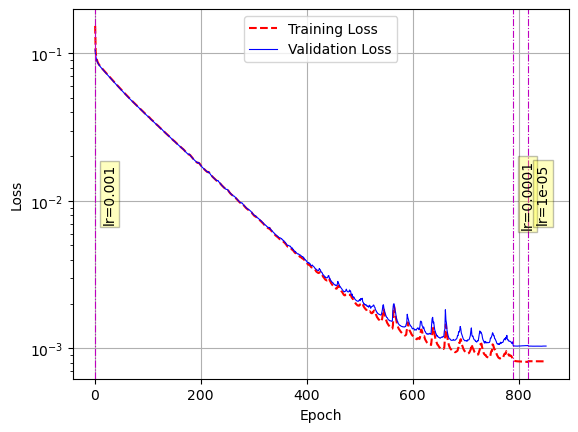

In [33]:
# plotting losses
dir_name_plot = dir_name_rnn+dir_sep+'plots'
if not os.path.isdir(dir_name_plot):
    os.makedirs(dir_name_plot)

# Visualize loss history
fig, ax = plot_losses(
    training_loss=train_loss_hist,
    val_loss=val_loss_hist,
    lr_change=lr_change,
    learning_rate_list=learning_rate_list
)

plt.savefig(dir_name_rnn+'{ds}plots{ds}loss_history.png'.format(ds=dir_sep), dpi=300, bbox_inches='tight')
plt.show()


data_idx : 10


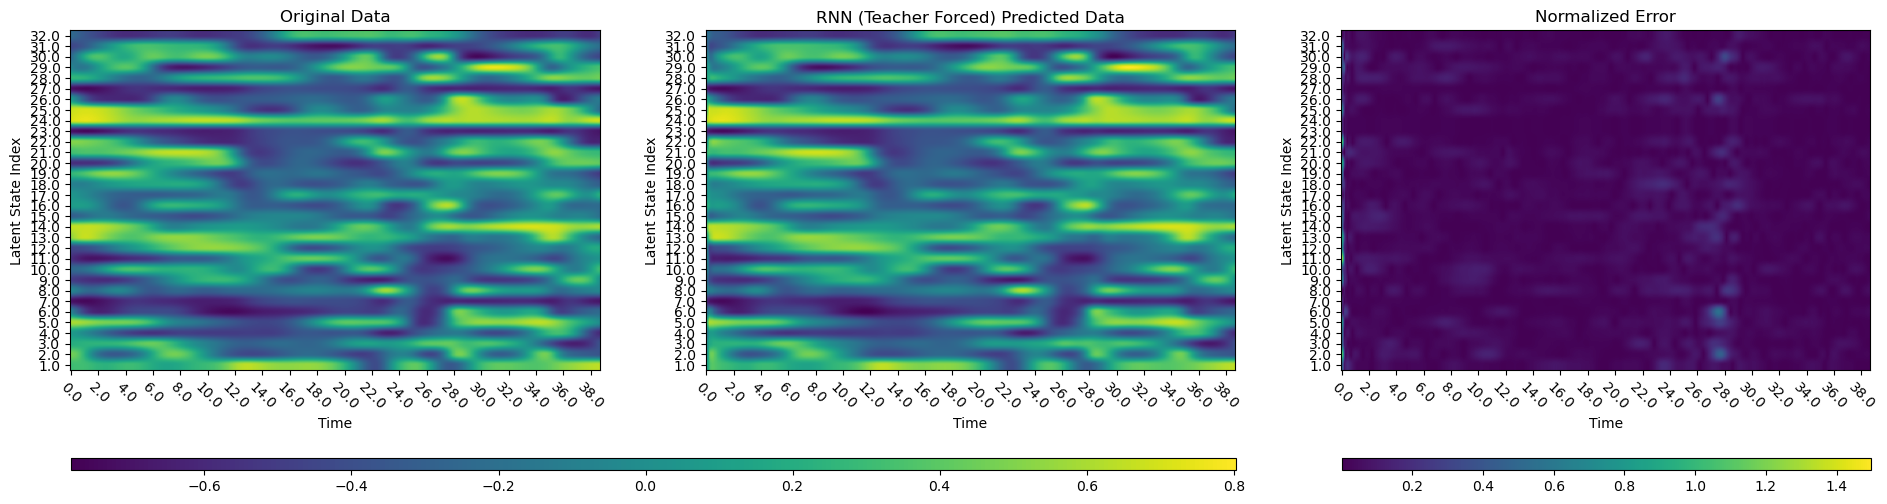

In [34]:
# data_type = 'training'
data_type = 'testing'

data_in = eval(data_type+'_data_rnn_input')
data_out = eval(data_type+'_data_rnn_output')

data_idx = np.arange(data_in.shape[0])
np.random.shuffle(data_idx)
data_idx = data_idx[0]
# data_idx = 3788
print('data_idx : {}'.format(data_idx))

# data_in = data_in[data_idx]
data_out = data_out[data_idx]

prediction = rnn_net.predict(data_in[data_idx:data_idx+1, :, :])

plot_reconstructed_data_KS(
    [data_out.shape[0]],
    dir_name_ae,
    data_out,
    prediction[0], delta_t, 1+np.arange(0, data_out.shape[1]),
    save_figs=False,
    normalization_constant_arr=normalization_arr,
    xticks_snapto=2,
    num_yticks=data_out.shape[1],
    ylabel=r'Latent State Index',
    ax1_title=r'Original Data',
    ax2_title=r'RNN (Teacher Forced) Predicted Data')

In [35]:
prediction.shape, data_out.shape

((1, 387, 32), (387, 32))